# Individual Income Tax Prediction

## Overview

After the tax reform recently, articles and analysis about tax are everywhere. Working as a tax analyst, I conduct data analysis over financial data every day for tax purposes, but I still find it is a pain to fill out my own individual tax return every year. You might think we can use Turbo tax or other tax preparation software to get them done, but were you ever curious about the amount you paid compared to others. Did you pay more than others or less? How’s the tax payment distribution amount US like? There are also people who have income other than salary need to figure out how much estimated tax they should pay by the end of the year to avoid fines and penalties. 

US has a very complicated tax system that not everyone has time to fully understand. Errors might happen when people type in or write down the wrong amount, and no one wants to be audited or get penalties from IRS. There is no benchmark for people to estimate their tax, other than their previous year return. What should we do if this is the first year return? What should we do if our income structure changes completely? How to minimize the potential errors? IRS has the database of the tax information in US for the past several years. If we have a model that can predict roughly about how much tax we owe each year, we will be able to understand if we need to pay estimate tax or if there might be some potential errors. 

## Problem Statement

As discussed above, it is hard for each individual to understand how much tax they need to pay each year. People are vulnerable if they do not know if they need to pay an estimate tax or if they have paid the right amount. How to avoid these situations? The potential solution is to build up a model to estimate how much tax they should pay. In this way, there will be a benchmark for people to compare to so that they know if there are abnormal amount caused by errors or other factors.

## Metrics

There are many simple free models online, such as [smart assets]( https://smartasset.com/taxes/income-taxes), that can be used as a benchmark. However, since similar models only take salary into account, the amount my model calculated could be different from them. We can use the real data from IRS to test the free model online and my model. The less difference between calculated amount and the real amount, the better the model is. This is more a regression model other than a classification model, so the percentage of differences can be a good measure.


## Dataset

The dataset can be found in [Kaggle](https://www.kaggle.com/irs/individual-income-tax-statistics/data) or [IRS](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi). It is saved separately as csv files for analysis. The detail information about column name and explanation can be found in "field_definitions.csv" file. Detail information can also be found in [IRS](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi). The original dataset is not consistent each year, so I will only use the following columns for this analysis. I have manipulate them to make it easiler to understand. The number in the original dataset is the total amount per zipcode.

* state - 2 letter state abbreviation
* agi_class
* num_of_returns - number of returns
* num_of_exemptions - number total exemptions
* num_of_dependents - number of total dependents
* num_of_itemized - total number of returns with itemized deduction
* agi - AGI
* total_salary - total amount of salaries & wages
* taxable_interest - total amount of taxable interest
* ordinary_dividend - total amount of ordinary dividend
* net_capital_gl - net amount of capital gain/loss
* total_tax - Total income tax amount
* prep - Number of returns using a Paid Preparer

AGI_Stub information shows below:

* 1 = \$1 under \$25,000 
* 2 = \$25,000 under \$50,000 
* 3 = \$50,000 under \$75,000 
* 4 = \$75,000 under \$100,000 
* 5 = \$100,000 under \$200,000 
* 6 = \$200,000 or more

## Getting Started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
%run read_files.py

## Initial Data Exploration

In [7]:
raw_data.sample(5)

,agi,agi_class,net_capital_gl,num_of_dependents,num_of_exemptions,num_of_itemized,num_of_returns,ordinary_dividend,prep,qualified_dividend,real_estate,state,taxable_interest,total_salary,total_tax,year
104555,6768.0,3,172,210.0,80,50,110.0,57,587,40.0000,50,NY,22,4136,235,2012
58002,676.0,1,0,60.0,40,0,60.0,11,16,0.0000,0,LA,4,580,0,2013
153220,391.0,1,0,17.0,93,-1905,85.0,76,62,NaN,NaN,NE,9,29,19,2006
115724,8499.0,3,0.0001,359.0,88,128,138.0,27,654,0.0001,74,OH,37,6524,124,2011
80479,284778.0,1,.,218.0,58,24,158.0,.,2009,NaN,.,KY,26794,164796,.,2007


In [3]:
%run read_files.py

After reading the data, it needs to be cleaned and change to the correct format for further analysis.

In [4]:
raw_data.head()

,state,zipcode,agi_class,num_of_returns,agi,total_wages,total_capital_gl,total_tax,prep,year
0,AK,99501,1.0,1459.0,1709,5588.0,209,116,730,2005
1,AK,99501,2.0,1713.0,29943,24052.0,180,1436,927,2005
2,AK,99501,3.0,1896.0,67861,57409.0,586,5896,905,2005
3,AK,99501,4.0,839.0,51347,36871.0,1687,6245,467,2005
4,AK,99501,5.0,417.0,35984,24282.0,981,5134,227,2005


In [5]:
raw_data.dtypes

state                object
zipcode               int64
agi_class           float64
num_of_returns      float64
agi                  object
total_wages         float64
total_capital_gl     object
total_tax            object
prep                 object
year                  int64
dtype: object

In [6]:
raw_data['agi_class'] = raw_data['agi_class'].astype('object')

In [7]:
raw_data[['agi', 'total_capital_gl', 'total_tax', 'prep']] = raw_data[
    ['agi', 'total_capital_gl', 'total_tax', 'prep']].apply(pd.to_numeric, errors='coerce')

In [8]:
raw_data.dtypes

state                object
zipcode               int64
agi_class            object
num_of_returns      float64
agi                 float64
total_wages         float64
total_capital_gl    float64
total_tax           float64
prep                float64
year                  int64
dtype: object

In [9]:
raw_data.shape

(1953802, 10)

In [10]:
raw_data.describe()

,zipcode,num_of_returns,agi,total_wages,total_capital_gl,total_tax,prep,year
count,1.953802e+06,1.931287e+06,1.922207e+06,1.928778e+06,1.892918e+06,1.872302e+06,1.910656e+06,1.953802e+06
mean,4.241869e+04,1.313526e+03,8.434421e+03,8.550801e+06,6.079098e+06,5.754828e+05,1.085569e+06,2.009570e+03
std,3.059228e+04,3.329159e+04,6.322080e+04,6.023600e+07,3.450416e+07,1.647389e+07,1.294756e+07,3.339095e+00
min,0.000000e+00,0.000000e+00,-4.407640e+05,-8.545497e+06,-1.298000e+03,-2.309389e+06,0.000000e+00,2.005000e+03
25%,1.471500e+04,5.000000e+01,5.100000e+01,3.625000e+03,5.050000e+02,1.000000e-04,1.200000e+02,2.006000e+03
50%,4.205800e+04,1.900000e+02,2.500000e+02,2.127500e+04,9.930000e+03,2.340000e+02,1.100000e+03,2.010000e+03
75%,6.743800e+04,8.200000e+02,1.350000e+03,1.980748e+05,1.510032e+05,2.863000e+03,1.415100e+04,2.013000e+03
max,9.999900e+04,1.557362e+07,1.791496e+07,1.516317e+10,5.177843e+09,7.993815e+09,3.872201e+09,2.015000e+03


## Explore the Dataset

### Number of Returns per year

To answer my initial question, I want to see how many people file returns each year, and whether it keeps increasing each year.

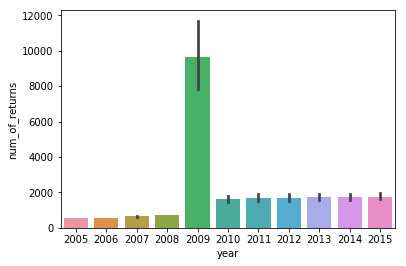

In [94]:
sns.barplot(data=raw_data, x='year', y='num_of_returns')

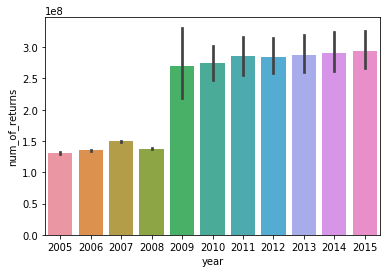

In [97]:
sns.barplot(data=raw_data, x='year', y='num_of_returns', estimator=np.sum)

This is very interesting since the number of returns should not change so dramatically. It might be something hidden in the data. 

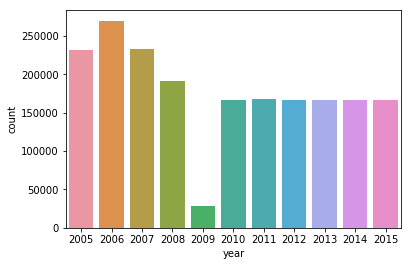

In [11]:
sns.countplot(data=raw_data, x='year')

This explans the sky-high average number of return in 2009. Although the total amount of returns seems right, the data point is much less than the other years. After reading through the documents, I did not find any reasons why it is significantly less than the other years. I assume that many zipcodes were grouped together in 2009. 

Since there is no way to fix it, the plot with average number will not be approprite. The future plots will focus on total amount.

Put the 2009 issue aside, the total number of returns jumped almost twice from 2008 to 2009. Since there is no documents in IRS explained the possible reasons, I would assume this is because of the financial crisis. More people are filing returns to get tax refund or figuring out their situations because of the financial crisis. After 2009, the total amount increased slightly each year.

### Paid Preparer

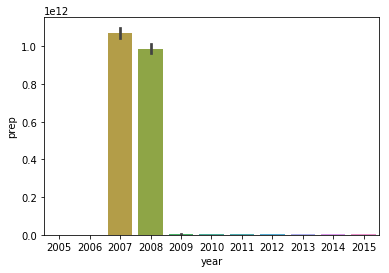

In [18]:
sns.barplot(data=raw_data, x='year', y='prep', estimator=np.sum)

In [14]:
prep = pd.pivot_table(raw_data, values='prep', 
                      index=['year'], columns=['state'], aggfunc=np.sum, margins=True)

In [17]:
prep['All']

year
2005    7.964807e+07
2006    8.222484e+07
2007    1.070869e+12
2008    9.871033e+11
2009    1.763429e+09
2010    1.939648e+09
2011    2.073536e+09
2012    2.335302e+09
2013    2.410683e+09
2014    2.665880e+09
2015    2.826148e+09
All     2.074149e+12
Name: All, dtype: float64

In [91]:
raw_data[raw_data['year'] == 2009]['num_of_returns'].mean()

9655.720561317878

In [92]:
raw_data[raw_data['year'] == 2010]['num_of_returns'].mean()

1642.2794369955084

In [98]:
num_of_return = pd.pivot_table(raw_data, values='num_of_returns',
                         index=['year'], columns=['state'], aggfunc=np.sum, margins=True)
num_of_return['All']

year
2005    1.305613e+08
2006    1.349555e+08
2007    1.491447e+08
2008    1.376662e+08
2009    2.690373e+08
2010    2.742968e+08
2011    2.853566e+08
2012    2.842682e+08
2013    2.875209e+08
2014    2.900781e+08
2015    2.939092e+08
All     2.536795e+09
Name: All, dtype: float64

In [83]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [88]:
tips[tips['day'] == 'Sun']['total_bill'].mean()

21.410000000000004

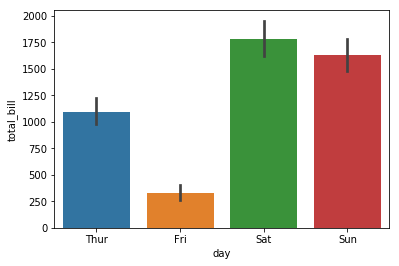

In [95]:
sns.barplot(data=tips, x='day', y='total_bill', estimator=sum)